# Libraries

In [1]:
# For handling data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# For Outlier Detection
from sklearn.ensemble import IsolationForest

# For Dimensionality Reduction
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For evaluating the performance of the preprocessing
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# For machine learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import keras
from keras import layers
from keras.layers import Activation, Dense

## Own functions

In [2]:
# Custom error function and submission saving function
def mean_euclidean_distance_error(estimator, X_test, y_test):
    from scipy.spatial.distance import euclidean
    import numpy as np
    y_pred = estimator.predict(X_test)
    euclidean_distances = [euclidean(y_test_i, y_pred_i) for y_test_i, y_pred_i in zip(y_test, y_pred)]
    return np.mean(euclidean_distances), np.std(euclidean_distances)

def save_submission(path, y_pred):
    import csv
    n_submissions = int(input("Ingrese el número de submission: "))
    author = input("Ingrese su nombre: ").upper()
    with open(f'./Submissions/submission{n_submissions}_{author[0]}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Id', 'Predicted'])
        for i, (x, y) in enumerate(y_pred):
            writer.writerow([i, f"{x}|{y}"])

class RandomizedSearchHO():
    def __init__(self, estimator, param_distributions, n_iter=10, scoring=None):
        self.__estimator = estimator
        self.__param_distributions = param_distributions
        self.__n_iter = n_iter
        self.__scoring = scoring
        self.best_params_ = None
        self.best_estimator_ = None
        self._best_score = None
        self.ho_results = {param: [] for param in self.__param_distributions.keys()}
        self.ho_results['score'] = []

    def fit(self, X, y):
        from sklearn.base import clone
        from sklearn.model_selection import train_test_split
        import numpy as np
        from itertools import product

        # Let's split X, y into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=8)

        # Let's sample the param_grid
        samples_param_grid = np.random.choice([{param: param_value  for param, param_value in zip(self.__param_distributions.keys(), param_values)} for param_values in product(*self.__param_distributions.values())], self.__n_iter, replace=False)

        # Let's train the models
        for i, param_sample in enumerate(samples_param_grid):
            print(f"Training model {i+1}/{self.__n_iter}")
            # We clone the estimator because we want to keep the best one
            estimator = clone(self.__estimator)

            # We set the parameters of the estimator and we fit it
            estimator.set_params(**param_sample)
            estimator.fit(X_train, y_train)

            # We evaluate the estimator
            current_score = self.__scoring(estimator, X_val, y_val)

            # We save the results            
            for param in param_sample:
                self.ho_results[param].append(param_sample[param])
            self.ho_results['score'].append(current_score)

            # We update the best estimator
            if i == 0:
                self.best_params_ = param_sample
                self.best_estimator_ = estimator
                self._best_score = current_score
            else:
                if current_score < self._best_score:
                    self.best_params_ = param_sample
                    self.best_estimator_ = estimator
                    self._best_score = current_score

            print(f"Hyperparameters: {param_sample}")
            print(f"Score: {current_score}")
            print("--------------------------------------------------"*50)
            
        return self
    
    def predict(self, X):
        return self.best_estimator_.predict(X)
    
class SFSExtractor(object):
    def __init__(self, features_selected):
        self.selected_features = features_selected
    def transform(self, X):
        return X.loc[:, self.selected_features]
    
    def fit(self, X, y=None):
        return self


# Understanding the database ```development.csv```

In [68]:
path = './DSL_Winter_Project_2024/'
df = pd.read_csv(path + 'development.csv')

In [69]:
# Let's see what we have
df.head()

,x,y,pmax[0],negpmax[0],area[0],tmax[0],rms[0],pmax[1],negpmax[1],area[1],...,pmax[16],negpmax[16],area[16],tmax[16],rms[16],pmax[17],negpmax[17],area[17],tmax[17],rms[17]
0,200.0,200.0,4.066907,-17.690173,2.847932,0.600000,2.007042,5.409161,-17.721210,4.538778,...,607.109118,-36.282996,583.899899,72.373094,0.374498,614.916861,-39.848523,591.852768,72.331028,0.405595
1,200.0,200.0,5.916801,-4.717111,5.792778,79.765174,1.564535,4.414289,-4.736827,3.720435,...,630.348007,-39.715988,580.042799,71.029155,0.403258,624.950701,-41.266681,586.569646,71.089058,0.405890
2,200.0,200.0,4.286652,-5.316132,2.356390,74.600000,1.404622,4.567191,-5.985437,3.490490,...,613.880342,-40.679678,580.407491,71.892264,0.568777,596.437125,-42.712286,574.091695,71.943934,0.498019
3,200.0,200.0,4.003635,-4.617459,2.189005,43.000000,1.512162,5.019058,-4.229949,6.786200,...,600.714957,-43.206601,579.882635,72.357388,0.255483,591.763739,-50.681940,584.099483,72.333282,0.336454
4,200.0,200.0,4.448146,-4.848743,3.997002,196.667482,1.101113,3.250262,-5.783587,2.449456,...,609.723785,-43.570892,590.156125,71.249130,0.413855,606.917023,-49.923819,584.316142,71.242904,0.293824


In [70]:
# Let's split the data into X and y (We have two variables to predict: x and y)
X = df.loc[:, 'pmax[0]':]
y = df[['x', 'y']]

In [71]:
# There is not na data
X.isna().sum().sum()

0

In [ ]:
#Create the Feature with the names of the columns to work later
Features=np.array(X.columns)

## Correlated data

In [6]:
correlation_matrix = X.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

In [7]:
mask_gt = correlation_matrix >= 0.8 
mask_lt = correlation_matrix <= -0.8

In [8]:
correlated_features = []
for i, row in enumerate(correlation_matrix.index):
    for j, column in enumerate(correlation_matrix.columns):
        if mask_gt.loc[row, column] or mask_lt.loc[row, column]:
            if  i < j:
                correlated_features.append((row, column))
correlated_features

[('pmax[1]', 'area[1]'),
 ('pmax[3]', 'area[3]'),
 ('pmax[4]', 'area[4]'),
 ('pmax[5]', 'negpmax[5]'),
 ('pmax[5]', 'area[5]'),
 ('negpmax[5]', 'area[5]'),
 ('pmax[6]', 'area[6]'),
 ('pmax[8]', 'area[8]'),
 ('pmax[9]', 'area[9]'),
 ('pmax[10]', 'area[10]'),
 ('pmax[11]', 'area[11]'),
 ('pmax[13]', 'area[13]'),
 ('pmax[14]', 'area[14]'),
 ('tmax[15]', 'tmax[16]'),
 ('tmax[15]', 'tmax[17]'),
 ('tmax[16]', 'tmax[17]')]

# Split the data

In [9]:
# Let's split X, y into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=8)

# Let's split X_train_val and y_train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=8)

# Baseline
For evaluating the performance of the preprocessing step that we will make later, we need to have a reference, the reference will be our baseline.
We will obtain our baseline training a Random forest with default hyperparameters with ```X_train``` and ```y_train```

In [10]:
rf = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=8)
rf.fit(X_train, y_train)

How well is our prediction? Let's use ```mean_euclidean_distance_error``` given by the problem.
Reminder: Don't use ```X_test``` for taking decisions, it will be used at the final of the project

In [ ]:
mean_euclidean_distance_error(rf, X_val, y_val)

(4.834723840555868, 3.652871984431365)

# Feature Reduction

## Deleting correlated features
Our baseline will be 4.836, it's our reference for evaluating the performance of the preprocessing step.
Now, the first experiment that we will run is:
- Try to delete correlated features and evaluate the performance

Note: We consider that the features are highly correlated if the absolute value of the correlation is greater than 0.8.

In [ ]:
# We create a new X_train without the correlated features
redundant_features = [ redundant_feature for _, redundant_feature in correlated_features ]
X_train_without_correlated_features = pd.DataFrame(X_train, columns=X.columns).drop(columns=redundant_features).values

Now, let's evaluate the performance of the model without the correlated features

In [ ]:
rf_without_correlated_features = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=8)
rf_without_correlated_features.fit(X_train_without_correlated_features, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(), n_jobs=6)

In [ ]:
# Now, we create a new X_val without the correlated features
X_val_without_correlated_features = pd.DataFrame(X_val, columns=X.columns).drop(columns=redundant_features).values

In [ ]:
mean_euclidean_distance_error(rf_without_correlated_features, X_val_without_correlated_features, y_val)

(5.114980213252129, 3.770051238333816)

## Applying SFS on each feature extracted
We have seen that dropping the correlated features does not improve the performance of the regressor, now, let's try another approach:

Apply Sequential Feature Selection on each feature extracted (On ```pmax```, ```negpmax```, ...), this could be a solution for reducing noise in our dataset because in the description of the project says that there are only 12 pads but 18 readings of each features are provided (A subset of the 18 features, as such, does not contain actual readings but rather noise).

In [10]:
features_extracted = ['pmax', 'negpmax', 'tmax', 'area', 'rms']
SFS_params = { feature: {
    'estimator': MultiOutputRegressor(KNeighborsRegressor(n_jobs=-1), n_jobs=-1),
    'X': pd.DataFrame(X_train, columns=X.columns)[[f'{feature}[{i}]' for i in range(0, 17 + 1)]].values
    } for feature in features_extracted
}

In [11]:
SFSs = { feature: SequentialFeatureSelector(SFS_params[feature]['estimator'], n_features_to_select=12, n_jobs=-1) for feature in features_extracted }

In [12]:
for feature in features_extracted:
    print("Starting SFS with", feature)
    SFSs[feature].fit(SFS_params[feature]['X'], y_train)

Starting SFS with pmax
Starting SFS with negpmax
Starting SFS with tmax
Starting SFS with area
Starting SFS with rms


In [13]:
for i, feature in enumerate(features_extracted):
    print(feature, SFSs[feature].get_support())
    pd.DataFrame(SFS_params[feature]['X'], columns=[f'{feature}[{i}]' for i in range(0, 17 + 1)]).loc[:, SFSs[feature].get_support()].to_csv(path + f'X_{feature}.csv', index=False)

pmax [False  True False  True  True  True  True False  True  True  True  True
 False  True  True  True False False]
negpmax [False  True  True  True  True  True  True False  True  True  True  True
 False  True  True False False False]
tmax [False  True False  True  True  True False False  True False  True  True
 False  True  True  True  True  True]
area [False  True  True  True  True  True  True False  True  True  True  True
 False  True  True False False False]
rms [ True  True  True False  True  True  True  True False  True  True  True
 False False  True False False  True]


Let's see which features were selected by the Sequential Feature Selector

In [18]:
features_selected = []
for feature in features_extracted:
    features_selected.extend([f'{feature}[{i}]' for i in range(0, 17 + 1) if SFSs[feature].get_support()[i]])
    print(feature, pd.DataFrame(SFS_params[feature]['X'], columns=[f'{feature}[{i}]' for i in range(0, 17 + 1)]).loc[:, SFSs[feature].get_support()].columns)
print(features_selected)

pmax Index(['pmax[1]', 'pmax[3]', 'pmax[4]', 'pmax[5]', 'pmax[6]', 'pmax[8]',
       'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]', 'pmax[15]'],
      dtype='object')
negpmax Index(['negpmax[1]', 'negpmax[2]', 'negpmax[3]', 'negpmax[4]', 'negpmax[5]',
       'negpmax[6]', 'negpmax[8]', 'negpmax[9]', 'negpmax[10]', 'negpmax[11]',
       'negpmax[13]', 'negpmax[14]'],
      dtype='object')
tmax Index(['tmax[1]', 'tmax[3]', 'tmax[4]', 'tmax[5]', 'tmax[8]', 'tmax[10]',
       'tmax[11]', 'tmax[13]', 'tmax[14]', 'tmax[15]', 'tmax[16]', 'tmax[17]'],
      dtype='object')
area Index(['area[1]', 'area[2]', 'area[3]', 'area[4]', 'area[5]', 'area[6]',
       'area[8]', 'area[9]', 'area[10]', 'area[11]', 'area[13]', 'area[14]'],
      dtype='object')
rms Index(['rms[0]', 'rms[1]', 'rms[2]', 'rms[4]', 'rms[5]', 'rms[6]', 'rms[7]',
       'rms[9]', 'rms[10]', 'rms[11]', 'rms[14]', 'rms[17]'],
      dtype='object')
['pmax[1]', 'pmax[3]', 'pmax[4]', 'pmax[5]', 'pmax[6]', 'pmax[8]', 'pmax[

Now, we need to evaluate the performance of what we have done, let's transform ```X_train``` and ```X_val```

In [26]:
X_train_SFS = pd.DataFrame(X_train, columns=X.columns).loc[:, features_selected].values
X_val_SFS = pd.DataFrame(X_val, columns=X.columns).loc[:, features_selected].values

In [27]:
rf_SFS = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=-1)
rf_SFS.fit(X_train_SFS, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=8), n_jobs=-1)

In [28]:
mean_euclidean_distance_error(rf_SFS, X_val_SFS, y_val)

(4.7946876810603225, 3.6242248169455404)

We see that the performance has improved regarding our baseline

In [10]:
features_selected = ['pmax[1]', 'pmax[3]', 'pmax[4]', 'pmax[5]', 'pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]', 'pmax[15]', 'negpmax[1]', 'negpmax[2]', 'negpmax[3]', 'negpmax[4]', 'negpmax[5]', 'negpmax[6]', 'negpmax[8]', 'negpmax[9]', 'negpmax[10]', 'negpmax[11]', 'negpmax[13]', 'negpmax[14]', 'tmax[1]', 'tmax[3]', 'tmax[4]', 'tmax[5]', 'tmax[8]', 'tmax[10]', 'tmax[11]', 'tmax[13]', 'tmax[14]', 'tmax[15]', 'tmax[16]', 'tmax[17]', 'area[1]', 'area[2]', 'area[3]', 'area[4]', 'area[5]', 'area[6]', 'area[8]', 'area[9]', 'area[10]', 'area[11]', 'area[13]', 'area[14]', 'rms[0]', 'rms[1]', 'rms[2]', 'rms[4]', 'rms[5]', 'rms[6]', 'rms[7]', 'rms[9]', 'rms[10]', 'rms[11]', 'rms[14]', 'rms[17]']

In [11]:
X_train_SFS = pd.DataFrame(X_train, columns=X.columns).loc[:, features_selected].values
X_val_SFS = pd.DataFrame(X_val, columns=X.columns).loc[:, features_selected].values

## PCA

First, we need to scale the data

In [12]:
scaler = StandardScaler()
X_train_SFS_scaled = scaler.fit_transform(X_train_SFS)
X_val_SFS_scaled = scaler.transform(X_val_SFS)

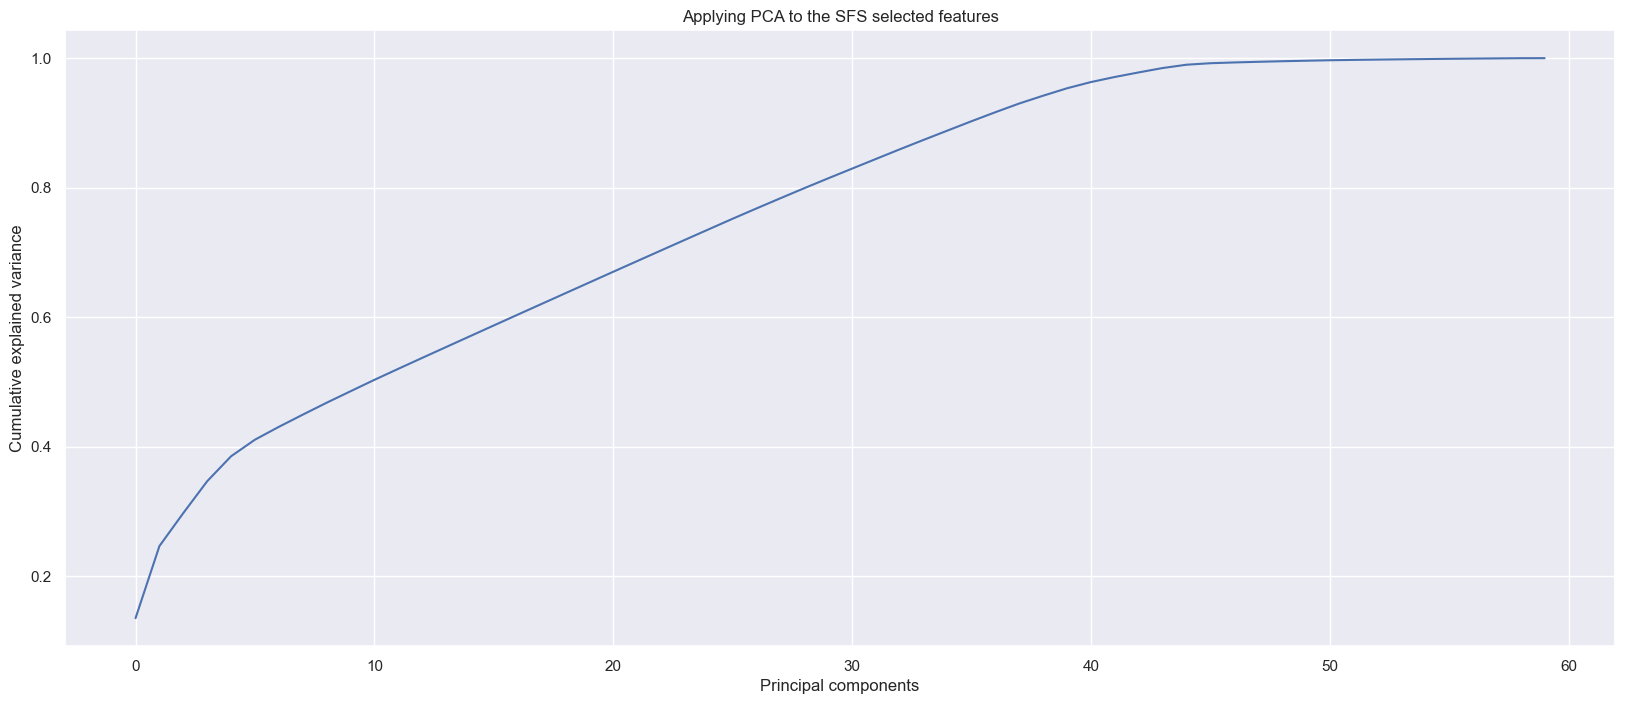

In [63]:
pca = PCA()

pca.fit(X_train_SFS_scaled)


plt.figure(figsize=(20,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Applying PCA to the SFS selected features')
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [14]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.13524268 0.24657519 0.2975449  0.34669563 0.38523661 0.41086356
 0.4306713  0.44945789 0.4678834  0.48560462 0.50323895 0.52026476
 0.53711959 0.55386315 0.57056569 0.58724913 0.60390118 0.62047729
 0.63704334 0.65359107 0.67011901 0.68659195 0.70301622 0.71940959
 0.73572538 0.75202799 0.7679605  0.78367502 0.7992186  0.81441414
 0.82940799 0.84435195 0.85925542 0.87385187 0.88823415 0.90258674
 0.91652344 0.9299821  0.94201587 0.95348397 0.96307869 0.97094235
 0.97799017 0.98473268 0.98986974 0.99219283 0.99338663 0.99438099
 0.99527964 0.99604689 0.99678281 0.99733767 0.99779419 0.99823095
 0.99863284 0.99901358 0.99934663 0.99966065 0.9999588  1.        ]


In [15]:
def findm(pca):
        m=0
        for i,var in enumerate(np.cumsum(pca.explained_variance_ratio_)):
                if var>=0.99:        
                        m=i+1 #It is +1 because the counting starts from 0
                        break    
        return m

In [16]:
n = findm(pca)
print(f"n = {n}")

n = 46


In [17]:
pca = PCA(n_components=n)
pca.fit(X_train_SFS_scaled)

PCA(n_components=46)

In [18]:
X_train_SFS_pca = pca.transform(X_train_SFS_scaled)
X_val_SFS_pca = pca.transform(X_val_SFS_scaled)

In [19]:
rf_SFS_pca = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=-1)
rf_SFS_pca.fit(X_train_SFS_pca, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=8), n_jobs=-1)

In [22]:
mean_euclidean_distance_error(rf_SFS_pca, X_val_SFS_pca, y_val)

(8.779834254269804, 7.516437715177231)

This approach does not improve our result obtained with feature selection, so, we discard this.

## Select the principal features suggested by the ```Random forest``` model

In [ ]:
sorted(zip(Features, rf.estimators_[0].feature_importances_), key=lambda x: x[1],reverse=True)
#The Feature importance to the y1 value : x

In [ ]:
sorted(zip(Features, rf.estimators_[1].feature_importances_), key=lambda x: x[1],reverse=True)
#The Feature importance to the y2 value : x

In [ ]:
mask=[i[0]!='t' for i in Features]
Features1=Features[mask] #Update the Features without the tmax's

Run again the model to see if it works

In [ ]:
#Update of the features and X

X1 = df.loc[:,Features1]

# Let's split X, y into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Let's split X_train_val and y_train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=8)

# Let's reset the indices
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
rf_1 = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=-1)
rf_1.fit(X_train, y_train)

In [ ]:
mean_euclidean_distance_error(rf_1, X_val, y_val.values) #The score has improve with respect to the baseline
#[4.814939299735663]

Review the importance of the Features according to the model now

In [ ]:
sorted(zip(Features1, rf_1.estimators_[0].feature_importances_), key=lambda x: x[1],reverse=True)
#The Feature importance to the y1 value : x
#pmax has increase its importance

In [ ]:
sorted(zip(Features1, rf_1.estimators_[1].feature_importances_), key=lambda x: x[1],reverse=True)
#The Feature importance to the y1 value : x
#pmax has increase its importance

¿What if we ake away the area[] information? Due to the hight correlatio with the p-value? 

## Model without tmax and area

In [ ]:
mask=[i[0]!='a' for i in Features]
Features2=Features1[mask] #Update the Features without the area's
#Update of the features and X

X2 = df.loc[:,Features2]

# Let's split X, y into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Let's split X_train_val and y_train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=8)

# Let's reset the indices
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
rf2 = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=-1)
rf2.fit(X_train, y_train)

In [ ]:
mean_euclidean_distance_error(rf, X_val, y_val.values) #The score has improve
#The metrics get worst, so we are going to keep the area features

## Ranks
Due to pmax and negpmax are the most important features of the model we could try to get the rank of the signals and score its importance in the model

In [ ]:
df3=df.copy()

In [ ]:
rank=np.zeros([18,len(df3['x'])])

for i in range(18):
        rank[i]=df3[f'pmax[{i}]']-df3[f'negpmax[{i}]']
        df3[f'rank[{i}]']=rank[i]
        df3.drop([f'pmax[{i}]',f'negpmax[{i}]'],axis=1, inplace=True)

In [ ]:
# Let's split the data into X and y (We have two variables to predict: x and y)
X = df3.loc[:, 'area[0]':]
y = df3[['x', 'y']]
Features=np.array(X.columns)

In [ ]:
# Let's split X, y into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=8)

# Let's split X_train_val and y_train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=8)

In [ ]:
rf = MultiOutputRegressor(RandomForestRegressor(random_state=8), n_jobs=-1)
rf.fit(X_train, y_train)
mean_euclidean_distance_error(rf, X_val, y_val.values)

In [ ]:
(sorted(zip(Features, rf.estimators_[0].feature_importances_), key=lambda x: x[1],reverse=True))
#The rank has more importance

In [ ]:
(sorted(zip(Features, rf.estimators_[1].feature_importances_), key=lambda x: x[1],reverse=True))
#The rank has more importance

## With rank and without tmax

In [ ]:
mask=[i[0]!='t' for i in Features]
Features1=Features[mask] #Update the Features without the tmax's
#y is the same than in the 2nd idea 
#X must be uploaded 
X1 = df3.loc[:,Features]

In [ ]:
# Let's split X, y into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=8)

# Let's split X_train_val and y_train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=8)

In [ ]:
rf1 = MultiOutputRegressor(RandomForestRegressor(), n_jobs=-1)
rf1.fit(X_train, y_train)
mean_euclidean_distance_error(rf1, X_val, y_val.values)
#Improve of the metric

## Outliers 
We are gonna try to use the before idea without ouliers

In [ ]:
isolation_forest = IsolationForest(n_estimators=1000)
X_train['is_outlier'] = isolation_forest.fit_predict(X_train) # fit_predict returns -1 for outliers and 1 for inliers

In [ ]:
mask_is_outlier = X_train['is_outlier'] == -1
X_train_without_outliers, y_train_without_outliers = X_train[~mask_is_outlier], y_train[~mask_is_outlier]
del(X_train_without_outliers['is_outlier'])
del(X_train['is_outlier'])

In [ ]:
plt.scatter(y_train.x[~mask_is_outlier], y_train.y[~mask_is_outlier], c='orange', label='inliers')
plt.scatter(y_train.x[mask_is_outlier], y_train.y[mask_is_outlier], c='red', label='outliers', alpha=0.3)

plt.show()
#The outliers signals are most of all in the borders. Althought it could be due to measurement instrument. 

In [ ]:
X_train_without_outliers.reset_index(drop=True, inplace=True)
y_train_without_outliers.reset_index(drop=True, inplace=True)
rf2 = MultiOutputRegressor(RandomForestRegressor())
rf2.fit(X_train_without_outliers, y_train_without_outliers)
mean_euclidean_distance_error(rf2, X_val, y_val.values)

# Model selection and hyperparameter tuning


In [ ]:
path = './DSL_Winter_Project_2024/'
df_dev = pd.read_csv(path + 'development.csv')
df_evaluation = pd.read_csv(path + 'evaluation.csv')

In [ ]:
X = df_dev.loc[:, 'pmax[0]':]
y = df_dev[['x', 'y']]

In [ ]:
# Let's split X, y into train_val and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=8)

In [ ]:
features_selected = ['pmax[1]', 'pmax[3]', 'pmax[4]', 'pmax[5]', 'pmax[6]', 'pmax[8]', 'pmax[9]', 'pmax[10]', 'pmax[11]', 'pmax[13]', 'pmax[14]', 'pmax[15]', 'negpmax[1]', 'negpmax[2]', 'negpmax[3]', 'negpmax[4]', 'negpmax[5]', 'negpmax[6]', 'negpmax[8]', 'negpmax[9]', 'negpmax[10]', 'negpmax[11]', 'negpmax[13]', 'negpmax[14]', 'tmax[1]', 'tmax[3]', 'tmax[4]', 'tmax[5]', 'tmax[8]', 'tmax[10]', 'tmax[11]', 'tmax[13]', 'tmax[14]', 'tmax[15]', 'tmax[16]', 'tmax[17]', 'area[1]', 'area[2]', 'area[3]', 'area[4]', 'area[5]', 'area[6]', 'area[8]', 'area[9]', 'area[10]', 'area[11]', 'area[13]', 'area[14]', 'rms[0]', 'rms[1]', 'rms[2]', 'rms[4]', 'rms[5]', 'rms[6]', 'rms[7]', 'rms[9]', 'rms[10]', 'rms[11]', 'rms[14]', 'rms[17]']

In [ ]:
preprocessing_pipeline = Pipeline([
    ('dim_red', SFSExtractor(features_selected)),
])

In [ ]:
X_train_SFS = preprocessing_pipeline.fit_transform(X_train).values
X_test_SFS = preprocessing_pipeline.transform(X_test).values

## Param grid of the different estimators

In [ ]:
rf_param_grid = {
    'estimator__n_estimators': [50, 100, 200, 400, 600, 1000],
    'estimator__max_features': ['sqrt', None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__bootstrap': [True, False],
    'estimator__criterion': ["squared_error", "poisson"],
    'estimator__n_jobs': [-1],
}

gb_param_grid = {
    'estimator__n_estimators': [50, 100, 200, 400, 600, 1000],
    'estimator__loss': ['huber', 'squared_error', 'absolute_error'],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
    'estimator__max_depth': [3, 7, 13, 19, 29],
}

knn_param_grid = {
    'estimator__n_neighbors': [7, 9, 11, 13, 15],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__p': [1, 2, 3, 4],
}

svr_param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'estimator__kernel': ['rbf', 'poly', 'sigmoid'],
    'estimator__degree': [3, 4, 5],
    'estimator__epsilon': [0.01, 0.1, 1, 10],
}

mlp_param_grid = {
    'estimator__hidden_layer_sizes': [(7,), (7,7,7), (16, 16, 16), (64, 64, 64), (128, 128, 128) ],
    'estimator__activation': ['tanh', 'relu'],
    'estimator__solver': ['sgd', 'adam'],
    'estimator__alpha': [0.0001, 0.001, 0.05],
    'estimator__learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 1000, 10000],
}

## Random forest
- Using the approach Sequential Feature Selection

In [ ]:
rf_randomized_search = RandomizedSearchHO(MultiOutputRegressor(RandomForestRegressor()), rf_param_grid, 10, scoring=mean_euclidean_distance_error)
rf_randomized_search.fit(X_train_SFS, y_train)

Training model 1/10
Hyperparameters: {'estimator__n_estimators': 100, 'estimator__max_features': None, 'estimator__min_samples_split': 2, 'estimator__bootstrap': True, 'estimator__criterion': 'squared_error', 'estimator__n_jobs': -1}
Score: (4.783390094179218, 3.5987518984947062)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

MemoryError: 

In [ ]:
rf_randomized_search.best_params_, mean_euclidean_distance_error(rf_randomized_search, X_test_SFS, y_test)

NameError: name 'rf_randomized_search' is not defined

## Gradient Boosting
- Using the approach Sequential Feature Selection

In [ ]:
gb_randomized_search = RandomizedSearchHO(MultiOutputRegressor(GradientBoostingRegressor()), gb_param_grid, 10, scoring=mean_euclidean_distance_error)
gb_randomized_search.fit(X_train_SFS, y_train)

In [ ]:
gb_randomized_search.best_params_, mean_euclidean_distance_error(gb_randomized_search, X_test_SFS, y_test)

## Support Vector Regression
- Using the approach Sequential Feature Selection

In [ ]:
svr_randomized_search = RandomizedSearchHO(MultiOutputRegressor(SVR()), svr_param_grid, 10, scoring=mean_euclidean_distance_error)
svr_randomized_search.fit(X_train_SFS, y_train)

In [ ]:
svr_randomized_search.best_params_, mean_euclidean_distance_error(svr_randomized_search, X_test_SFS, y_test)

## MLP
- Using the approach Sequential Feature Selection

In [ ]:
mlp_randomized_search = RandomizedSearchHO(MultiOutputRegressor(MLPRegressor()), mlp_param_grid, 10, scoring=mean_euclidean_distance_error)
mlp_randomized_search.fit(X_train_SFS, y_train)

In [ ]:
mlp_randomized_search.best_params_, mean_euclidean_distance_error(mlp_randomized_search, X_test_SFS, y_test)

## KNN
- Using the approach Sequential Feature Selection

In [ ]:
knn_randomized_search = RandomizedSearchHO(MultiOutputRegressor(KNeighborsRegressor()), knn_param_grid, 10, scoring=mean_euclidean_distance_error)
knn_randomized_search.fit(X_train_SFS, y_train)

In [ ]:
knn_randomized_search.best_params_, mean_euclidean_distance_error(knn_randomized_search, X_test_SFS, y_test)

## RNN

In [ ]:
n_inputs,n_outputs=X_train_without_outliers.shape[1],y_train_without_outliers.shape[1]
model = keras.Sequential()
model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.fit(X_train_SFS, y_train, epochs=100)
mean_euclidean_distance_error(model, X_test_SFS,  y_test)
